# K-means to segment Customers based on RFM Variables

In [ ]:
!pip install feature_engine

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import plotly.offline as pyoff
import plotly.graph_objs as go

import datetime as dt
import feature_engine

from feature_engine.outliers import Winsorizer

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Load Dataset
df = pd.read_csv('data.csv',encoding="ISO-8859-1")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,12/9/2011 12:50,4.95,12680.0,France


In [ ]:
df.shape

(541909, 8)

## Data Preparation

In [ ]:
def summary(df, pred=None):
  obs = df.shape[0]
  types = df.dtypes
  counts = df.apply(lambda x: x.count())
  min = df.min()
  uniques = df.apply(lambda x: x.unique().shape[0])
  nulls = df.apply(lambda x: x.isnull().sum())
  print('Data shape:', df.shape)

  if pred is None:
        cols = ['types', 'counts', 'uniques', 'nulls', 'min']
        str = pd.concat([types, counts, uniques, nulls, min], axis = 1, sort=True)

  str.columns = cols
  dtypes = str.types.value_counts()
  print('___________________________\nData types:')
  print(str.types.value_counts())
  print('___________________________')
  return str

details = summary(df)
display(details.sort_values(by='nulls', ascending=False))

Data shape: (541909, 8)
___________________________
Data types:
object     5
float64    2
int64      1
Name: types, dtype: int64
___________________________


,types,counts,uniques,nulls,min
CustomerID,float64,406829,4373,135080,12346.0
Description,object,540455,4224,1454,NaN
Country,object,541909,38,0,Australia
InvoiceDate,object,541909,23260,0,1/10/2011 10:04
InvoiceNo,object,541909,25900,0,536365
Quantity,int64,541909,722,0,-80995
StockCode,object,541909,4070,0,10002
UnitPrice,float64,541909,1630,0,-11062.06


In [ ]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [ ]:
df.loc[(df.UnitPrice<0)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,8/12/2011 14:51,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,8/12/2011 14:52,-11062.06,NaN,United Kingdom


In [ ]:
df.loc[(df.Quantity<0)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,12/9/2011 9:57,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,12/9/2011 10:28,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,12/9/2011 11:57,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,12/9/2011 11:58,1.25,17315.0,United Kingdom


**Observation:**

- The min and max value for Quantity is 80995, this could represent cancelled or returned orders.
- The UnitPrice also have few negative values which is uncommon,these transactions could represent cancelled orders by customers or bad-debt incurred by the business.
- Bad debt adjustments will be dropped from the dataset as these do not represent actual sales.

We need to clean the above values by removing from the dataset

In [ ]:
df.isnull().mean()*100

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

There are almost 25% missing CustomerID. We need to remove them as there is no way we can get the number of CustomerID

<b>As customer clusters may vary by geography, we will restrict the data to only United Kingdom customers, which contains most of our customers historical data.</b>

In [ ]:
df.Country.value_counts(normalize=True)

United Kingdom          0.914320
Germany                 0.017521
France                  0.015790
EIRE                    0.015124
Spain                   0.004674
Netherlands             0.004375
Belgium                 0.003818
Switzerland             0.003694
Portugal                0.002803
Australia               0.002323
Norway                  0.002004
Italy                   0.001482
Channel Islands         0.001399
Finland                 0.001283
Cyprus                  0.001148
Sweden                  0.000853
Unspecified             0.000823
Austria                 0.000740
Denmark                 0.000718
Japan                   0.000661
Poland                  0.000629
Israel                  0.000548
USA                     0.000537
Hong Kong               0.000531
Singapore               0.000423
Iceland                 0.000336
Canada                  0.000279
Greece                  0.000269
Malta                   0.000234
United Arab Emirates    0.000125
European C

We can see that there is maximum proportion (More than 90% of customers) of 'United Kingdom' customers. So we will take 'United Kingdom' customer for our analysis.

In [ ]:
df = df[df.Country == 'United Kingdom']

**Removing the negative values from UnitPrice and Quantity**

In [ ]:
df = df[df.Quantity > 0]
df = df[df.UnitPrice > 0]

#Removing the Null values from the data.
df = df[pd.notnull(df['CustomerID'])]

In [ ]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceYearMonth'] = df['InvoiceDate'].map(lambda date: 100*date.year + date.month)
df['Date'] = df['InvoiceDate'].dt.strftime('%Y-%m')

In [ ]:

#df['Date']=pd.to_datetime(df['Date'])

In [ ]:
df.isnull().mean()

InvoiceNo           0.0
StockCode           0.0
Description         0.0
Quantity            0.0
InvoiceDate         0.0
UnitPrice           0.0
CustomerID          0.0
Country             0.0
InvoiceYearMonth    0.0
Date                0.0
dtype: float64

**We have all the crucial information we need:**
- Customer ID
- Unit Price
- Quantity
- Invoice Date

**Aggregating the Orders by Month**

In [ ]:
df_agg= df.groupby("Date").Quantity.sum()
df_agg

Date
2010-12    267767
2011-01    278251
2011-02    213375
2011-03    276304
2011-04    260448
2011-05    301824
2011-06    280974
2011-07    303601
2011-08    310831
2011-09    454559
2011-10    476984
2011-11    571215
2011-12    260607
Name: Quantity, dtype: int64

In [ ]:
#converting series to dataframe and resetting index, and changing the column name to 'Orders'
df_agg=pd.DataFrame(df_agg)
df_agg=df_agg.reset_index()
df_agg.head()

,Date,Quantity
0,2010-12,267767
1,2011-01,278251
2,2011-02,213375
3,2011-03,276304
4,2011-04,260448


In [ ]:

def plot_df(df, x, y, title="", xlabel='Date', ylabel='Orders', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.plot(x, y, color='tab:Blue', marker='o')
    plt.show()

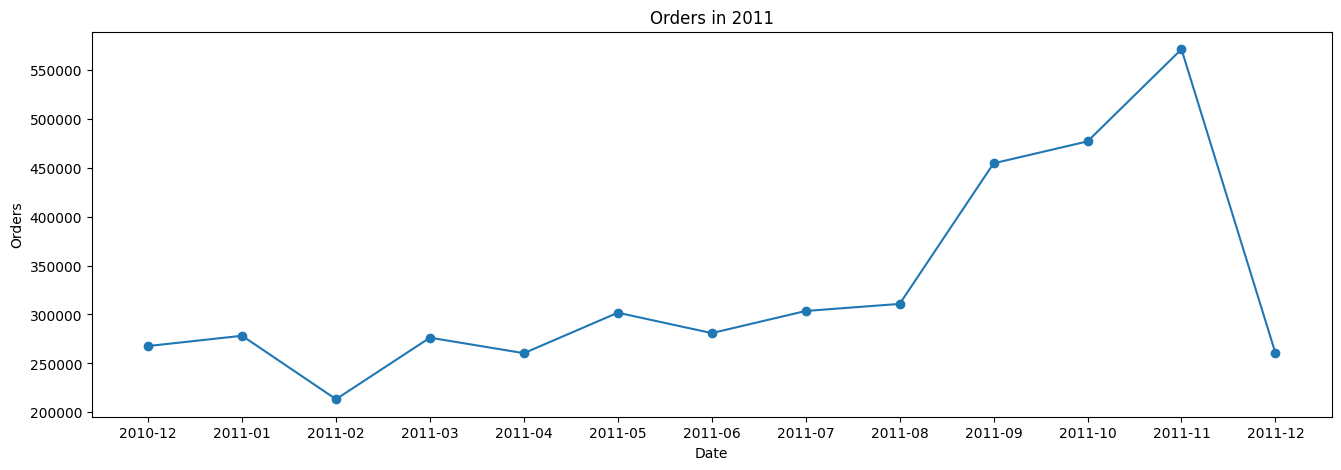

In [ ]:
plot_df(df_agg, x=df_agg.Date, y=df_agg.Quantity,title='Orders in 2011')

### Calculating  Revenue

**Revenue = Order Count * Average Revenue per Order**

In [ ]:
df['Revenue'] = df['Quantity']*df['UnitPrice']

In [ ]:
df['Quantity']

0          6
1          6
2          8
3          6
4          6
          ..
541889    12
541890     8
541891    24
541892    24
541893    10
Name: Quantity, Length: 354321, dtype: int64

<Axes: xlabel='Quantity'>

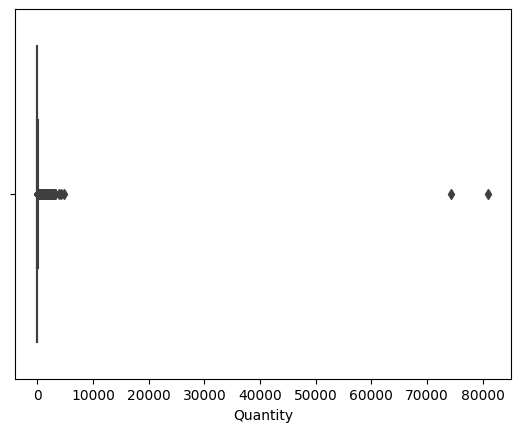

In [ ]:
sns.boxplot(x=df['Quantity'])

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth,Date,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,201012,2010-12,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,2010-12,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,201012,2010-12,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,2010-12,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,2010-12,20.34


### Monthly Revenue

In [ ]:
df_revenue = df.groupby(['InvoiceYearMonth'])['Revenue'].sum().reset_index()
df_revenue.head()

,InvoiceYearMonth,Revenue
0,201012,498661.850
1,201101,442190.060
2,201102,355655.630
3,201103,467198.590
4,201104,409559.141


In [ ]:
plot_data = [
    go.Scatter(
        x=df_revenue['InvoiceYearMonth'],
        y=df_revenue['Revenue'],
        mode='lines+markers'
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Montly Revenue'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

## RFM Analysis

<b>Recency-Frequency-Monetary
    
    
RFM analysis allows you to segment customers by the frequency and value of purchases and identify those customers who spend the most money.

* Recency — how long it’s been since a customer bought something from us
* Frequency — how often a customer buys from us
* Monetary value — the total value of purchases a customer has made</b>

<b>The last invoice date is 2011–12–09, we will use this date to calculate Recency.</b>

In [ ]:
NOW = dt.date(2011,12,9)
df['Date'] = pd.DatetimeIndex(df.InvoiceDate).date

#### Recency

In [ ]:
df_recency = df.groupby(['CustomerID'],as_index=False)['Date'].max()
df_recency.columns = ['CustomerID','Last_Purchase_Date']

df_recency['Recency'] = df_recency.Last_Purchase_Date.apply(lambda x:(NOW - x).days)
df_recency.drop(columns=['Last_Purchase_Date'],inplace=True)
df_recency.head()

,CustomerID,Recency
0,12346.0,325
1,12747.0,2
2,12748.0,0
3,12749.0,3
4,12820.0,3


#### Frequency - Monetarty

In [ ]:
FM_Table = df.groupby('CustomerID').agg({'InvoiceNo'   : lambda x:len(x),
                                         'Revenue'  : lambda x:x.sum()})
FM_Table.rename(columns = {'InvoiceNo' :'Frequency',
                           'Revenue':'Monetary'},inplace= True)
FM_Table.head()

,Frequency,Monetary
CustomerID,,
12346.0,1,77183.60
12747.0,103,4196.01
12748.0,4595,33719.73
12749.0,199,4090.88
12820.0,59,942.34


In [ ]:
RFM_Table = df_recency.merge(FM_Table,left_on='CustomerID',right_on='CustomerID')
RFM_Table.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12747.0,2,103,4196.01
2,12748.0,0,4595,33719.73
3,12749.0,3,199,4090.88
4,12820.0,3,59,942.34


In [ ]:
(NOW - dt.date(2011,1,18)).days == 325

True

<b>Now we split the metrics into segments using quantiles.
We will assign a score from 1 to 4 to each Recency, Frequency and Monetary respectively. 1 is the highest value, and 4 is the lowest value. A final RFM score (Overall Value) is calculated simply by combining individual RFM score numbers.</b>

In [ ]:
quantiles = RFM_Table.quantile(q=[0.25,0.50,0.75])
quantiles = quantiles.to_dict()

In [ ]:
segmented_rfm = RFM_Table.copy()

In [ ]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4

def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1

In [ ]:
segmented_rfm['R_quartile'] = segmented_rfm['Recency'].apply(RScore, args=('Recency',quantiles))
segmented_rfm['F_quartile'] = segmented_rfm['Frequency'].apply(FMScore, args=('Frequency',quantiles))
segmented_rfm['M_quartile'] = segmented_rfm['Monetary'].apply(FMScore, args=('Monetary',quantiles))
segmented_rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_quartile,F_quartile,M_quartile
0,12346.0,325,1,77183.60,4,4,1
1,12747.0,2,103,4196.01,1,1,1
2,12748.0,0,4595,33719.73,1,1,1
3,12749.0,3,199,4090.88,1,1,1
4,12820.0,3,59,942.34,1,2,2


**Calculating the total RFM score combined**

RFM_Score = R_quartile + F_quartile + M_quartile

In [ ]:
segmented_rfm['RFM_Segment'] = segmented_rfm.R_quartile.map(str)+segmented_rfm.F_quartile.map(str)+segmented_rfm.M_quartile.map(str)

In [ ]:
segmented_rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_quartile,F_quartile,M_quartile,RFM_Segment
0,12346.0,325,1,77183.60,4,4,1,441
1,12747.0,2,103,4196.01,1,1,1,111
2,12748.0,0,4595,33719.73,1,1,1,111
3,12749.0,3,199,4090.88,1,1,1,111
4,12820.0,3,59,942.34,1,2,2,122


In [ ]:
segmented_rfm['RFM_Score'] = segmented_rfm[['R_quartile','F_quartile','M_quartile']].sum(axis=1)

In [ ]:
segmented_rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_quartile,F_quartile,M_quartile,RFM_Segment,RFM_Score
0,12346.0,325,1,77183.60,4,4,1,441,9
1,12747.0,2,103,4196.01,1,1,1,111,3
2,12748.0,0,4595,33719.73,1,1,1,111,3
3,12749.0,3,199,4090.88,1,1,1,111,3
4,12820.0,3,59,942.34,1,2,2,122,5


In [ ]:
print("Best Customers: ",len(segmented_rfm[segmented_rfm['RFM_Segment']=='111']))
print('Loyal Customers: ',len(segmented_rfm[segmented_rfm['F_quartile']==1]))
print("Big Spenders: ",len(segmented_rfm[segmented_rfm['M_quartile']==1]))
print('Almost Lost: ', len(segmented_rfm[segmented_rfm['RFM_Segment']=='134']))
print('Lost Customers: ',len(segmented_rfm[segmented_rfm['RFM_Segment']=='344']))
print('Lost Cheap Customers: ',len(segmented_rfm[segmented_rfm['RFM_Segment']=='444']))

Best Customers:  409
Loyal Customers:  980
Big Spenders:  980
Almost Lost:  21
Lost Customers:  168
Lost Cheap Customers:  343


In [ ]:
segmented_rfm['RFM_Score'].unique()

array([ 9,  3,  5, 12,  7,  8,  6, 10, 11,  4])

In [ ]:
segmented_rfm.groupby('RFM_Score').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count'] }).round(1)

Recency Frequency Monetary      
             mean      mean     mean count
RFM_Score                                 
3             6.6     363.7   8218.2   409
4            20.3     187.0   3492.1   345
5            32.0     113.3   1909.4   386
6            47.0      78.9   1806.6   380
7            60.5      55.4    917.1   408
8            78.1      38.5    733.0   393
9            96.7      28.4    829.5   424
10          153.0      21.0    357.0   470
11          174.0      13.7    234.2   362
12          257.9       8.1    152.3   343

## K-means to perform RFM (Recency, Frequency, and Monetary) customer segmentation.

<b>K-means gives the best result under the following conditions:</b>
- <b>Data’s distribution is not skewed (i.e. long-tail distribution) </b>
- <b> Data is standardised (i.e. mean of 0 and standard deviation of 1).</b>

**Plotting distribution charts to check for skewness.**

In [ ]:
## Function to check skewness
def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column])
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

Recency's: Skew: 1.244516494686479, : SkewtestResult(statistic=25.283720058978158, pvalue=4.8246481722257944e-141)
Frequency's: Skew: 18.66163311873067, : SkewtestResult(statistic=80.10349526126947, pvalue=0.0)
Monetary's: Skew: 20.190728787200957, : SkewtestResult(statistic=81.75346911703686, pvalue=0.0)


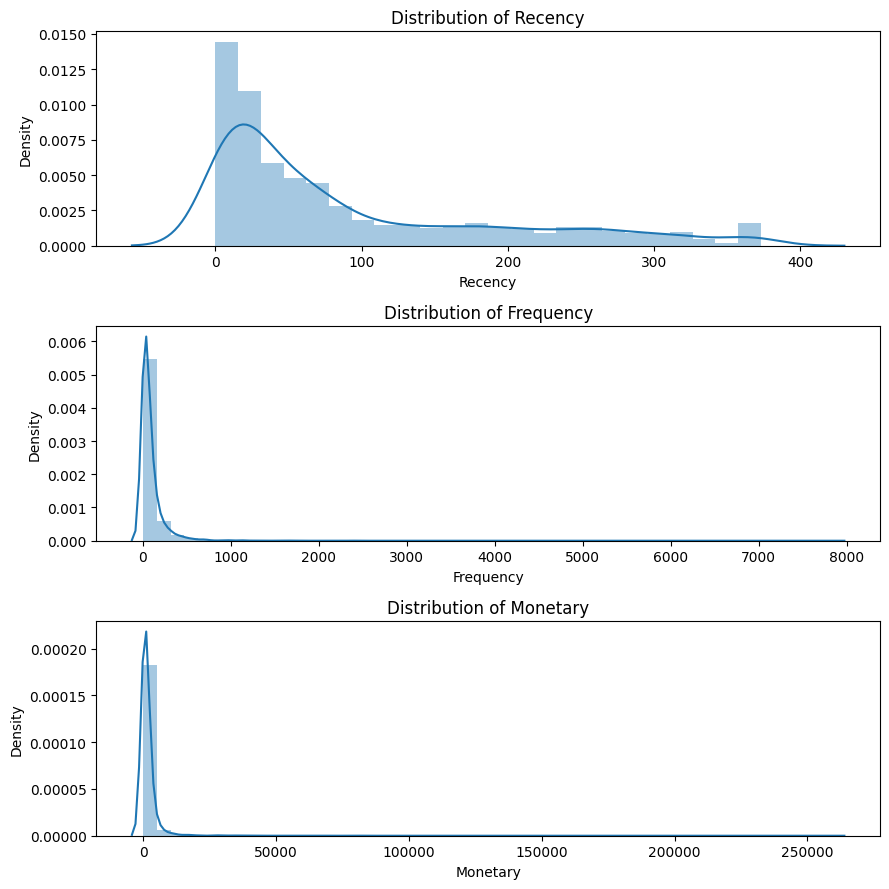

In [ ]:
# Plot all 3 graphs together for summary findings
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(RFM_Table,'Recency')

plt.subplot(3, 1, 2)
check_skew(RFM_Table,'Frequency')

plt.subplot(3, 1, 3)
check_skew(RFM_Table,'Monetary')

plt.tight_layout()

<b>The data is highly skewed,therefore we will perform log transformations to reduce the skewness of each variable. I added a small constant as log transformation demands all the values to be positive.</b>

In [ ]:
# cols=['Recency','Frequency','Monetary_Value']
# df_rfm_log = RFM_Table[cols]

In [ ]:
df_rfm_log = RFM_Table.copy()

In [ ]:
df_rfm_log.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12747.0,2,103,4196.01
2,12748.0,0,4595,33719.73
3,12749.0,3,199,4090.88
4,12820.0,3,59,942.34


Recency's: Skew: -0.4635591539552193, : SkewtestResult(statistic=-11.314301280234206, pvalue=1.114869536941138e-29)
Frequency's: Skew: -0.02600696239989871, : SkewtestResult(statistic=-0.6659021000684195, pvalue=0.5054736781086501)
Monetary's: Skew: 0.3694308288045071, : SkewtestResult(statistic=9.166088768517884, pvalue=4.904929990328552e-20)


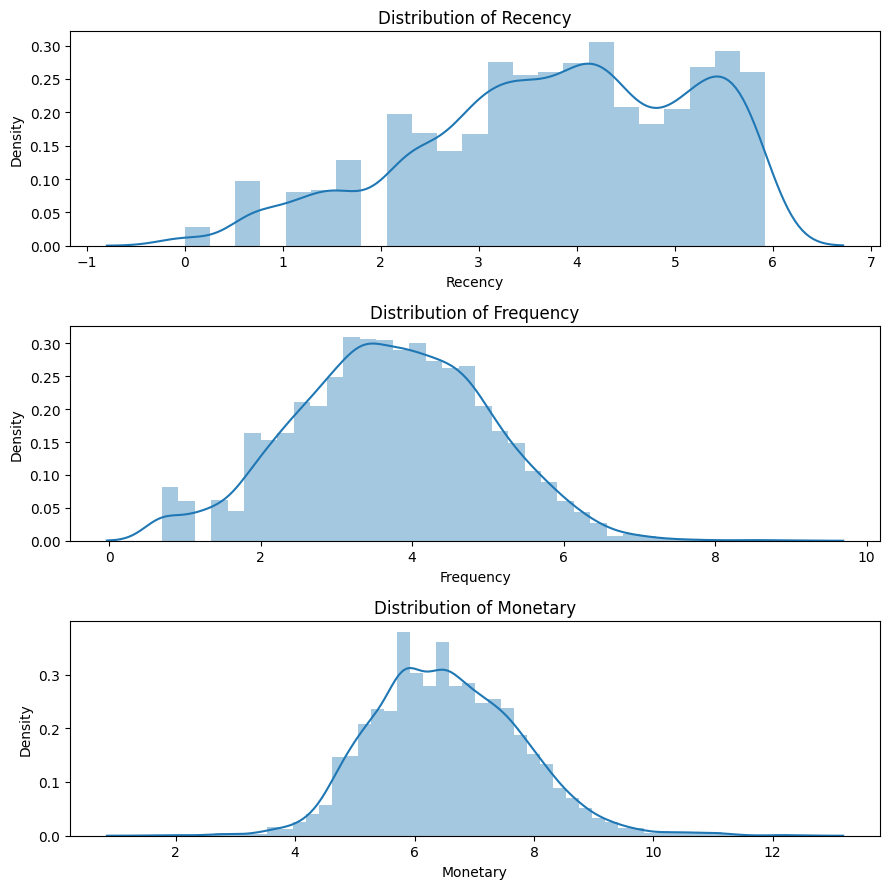

In [ ]:
df_rfm_log = np.log(df_rfm_log+1)

plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(df_rfm_log,'Recency')

plt.subplot(3, 1, 2)
check_skew(df_rfm_log,'Frequency')
plt.subplot(3, 1, 3)
check_skew(df_rfm_log,'Monetary')

plt.tight_layout()

In [ ]:
RFM_Table.describe()

,CustomerID,Recency,Frequency,Monetary
count,3920.000000,3920.000000,3920.000000,3920.000000
mean,15562.059694,91.742092,90.388010,1864.385601
std,1576.594671,99.533485,217.808385,7482.817477
min,12346.000000,0.000000,1.000000,3.750000
25%,14208.750000,17.000000,17.000000,300.280000
50%,15569.500000,50.000000,41.000000,652.280000
75%,16913.250000,142.000000,99.250000,1576.585000
max,18287.000000,373.000000,7847.000000,259657.300000


In [ ]:
windsoriser = Winsorizer(tail='both', # cap left, right or both tails
                          fold=2,
                           variables=[ 'Recency', 'Frequency', 'Monetary']
                        )
windsoriser.fit(df_rfm_log)

Winsorizer(fold=2, tail='both', variables=['Recency', 'Frequency', 'Monetary'])

In [ ]:
df_rfm_log = windsoriser.transform(df_rfm_log)

**Once the skewness is reduced, I standardised the data by centring and scaling. Note all the variables now have a mean of 0 and a standard deviation of 1.**

In [ ]:
scaler = StandardScaler()

scaler.fit(df_rfm_log)

RFM_Table_scaled = scaler.transform(df_rfm_log)

In [ ]:
RFM_Table_scaled = pd.DataFrame(RFM_Table_scaled, columns=df_rfm_log.columns)
RFM_Table_scaled.head()

,CustomerID,Recency,Frequency,Monetary
0,-2.216570,1.465314,-2.075553,2.144184
1,-1.903521,-2.017962,0.758501,1.551863
2,-1.902753,-2.065658,2.072989,2.144184
3,-1.901985,-1.804222,1.296773,1.530119
4,-1.847594,-1.804222,0.305737,0.272403


## K-Means Clustering

### Finding the optimal number of clusters

In [ ]:
from scipy.spatial.distance import cdist
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1,10)

for k in K:
    #Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(RFM_Table_scaled)
    kmeanModel.fit(RFM_Table_scaled)

    distortions.append(sum(np.min(cdist(RFM_Table_scaled, kmeanModel.cluster_centers_,
                      'euclidean'),axis=1)) / RFM_Table_scaled.shape[0])
    inertias.append(kmeanModel.inertia_)

    mapping1[k] = sum(np.min(cdist(RFM_Table_scaled, kmeanModel.cluster_centers_,
                 'euclidean'),axis=1)) / RFM_Table_scaled.shape[0]
    mapping2[k] = kmeanModel.inertia_

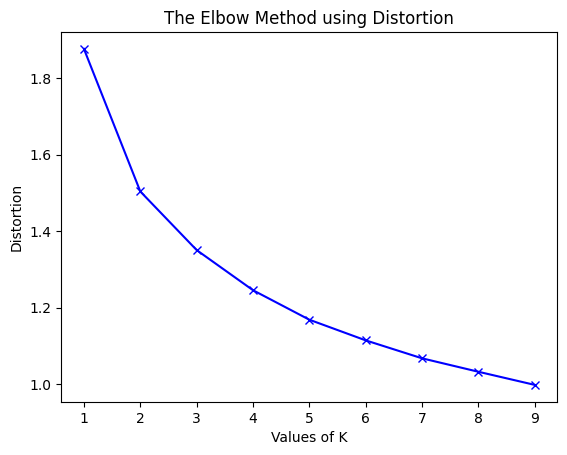

In [ ]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

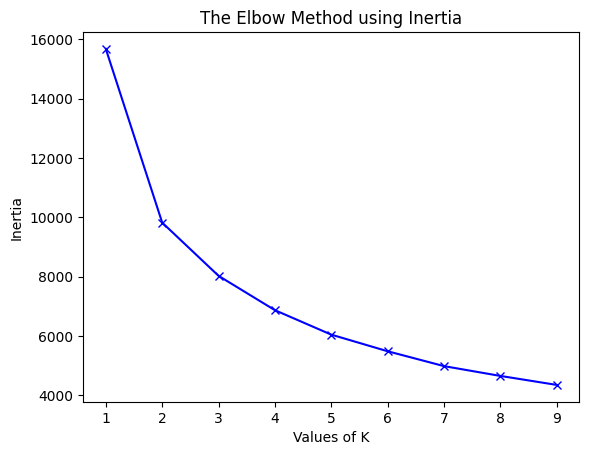

In [ ]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

<b>The cluster value where this decrease in inertia value becomes constant can be chosen as the right cluster value for our data. Looking at the above elbow curve, we can choose any number of clusters between 4 to 7.</b>

In [ ]:
def kmeans(normalised_df_rfm, clusters_number, original_df_rfm):

    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(normalised_df_rfm)

    # Extract cluster labels
    cluster_labels = kmeans.labels_

    # Create a cluster label column in original dataset
    df_new = original_df_rfm.assign(Cluster = cluster_labels)

    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)

    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")

    return df_new

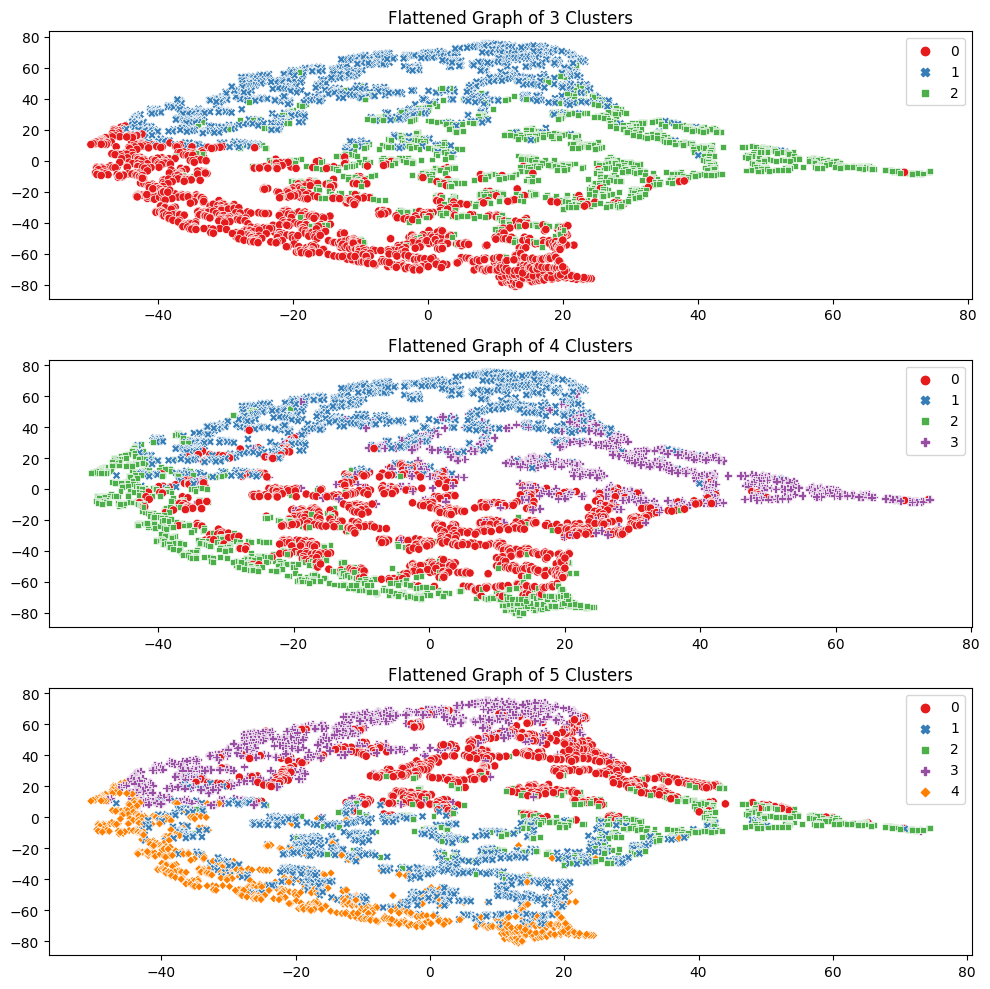

In [ ]:
plt.figure(figsize=(10, 10))

plt.subplot(3, 1, 1)
df_rfm_k3 = kmeans(RFM_Table_scaled, 3, RFM_Table)

plt.subplot(3, 1, 2)
df_rfm_k4 = kmeans(RFM_Table_scaled, 4, RFM_Table)

plt.subplot(3, 1, 3)
df_rfm_k5 = kmeans(RFM_Table_scaled, 5, RFM_Table)

plt.tight_layout()


In [ ]:

def snake_plot(normalised_df_rfm, df_rfm_kmeans, df_rfm_original):

    normalised_df_rfm = pd.DataFrame(normalised_df_rfm,
                                       index=RFM_Table.index,
                                       columns=RFM_Table.columns)
    normalised_df_rfm['Cluster'] = df_rfm_kmeans['Cluster']

    # Melt data into long format
    df_melt = pd.melt(normalised_df_rfm.reset_index(),
                        id_vars=['CustomerID', 'Cluster'],
                        value_vars=['Recency', 'Frequency', 'Monetary'],
                        var_name='Metric',
                        value_name='Value')

    plt.xlabel('Metric')
    plt.ylabel('Value')
    sns.pointplot(data=df_melt, x='Metric', y='Value', hue='Cluster')

    return

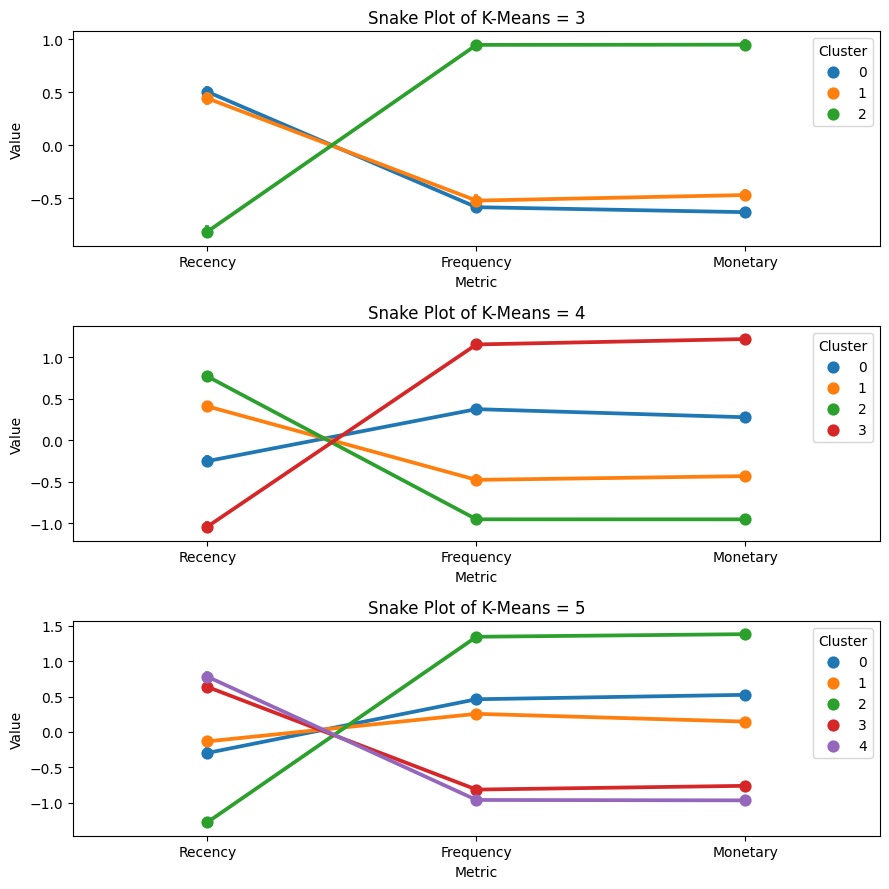

In [ ]:
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
plt.title('Snake Plot of K-Means = 3')
snake_plot(RFM_Table_scaled, df_rfm_k3, RFM_Table)

plt.subplot(3, 1, 2)
plt.title('Snake Plot of K-Means = 4')
snake_plot(RFM_Table_scaled, df_rfm_k4, RFM_Table)

plt.subplot(3, 1, 3)
plt.title('Snake Plot of K-Means = 5')
snake_plot(RFM_Table_scaled, df_rfm_k5, RFM_Table)

plt.tight_layout()

<b>From the flattened graphs and the snake plots it is evident that having a cluster value of 4,segments our customers well.
   We could also go for higher number of clusters, it completely depends on how the company wants to segment their customers.</b>

### Interpretation of the clusters formed using k-means .


In [ ]:
def rfm_values(df):

    df_new = df.groupby(['Cluster']).agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary': ['mean', 'count']
    }).round(0)

    return df_new

In [ ]:
rfm_values(df_rfm_k4)

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0          51.0      83.0   1404.0  1060
1         120.0      31.0    671.0  1077
2         174.0      16.0    288.0   925
3          18.0     255.0   5631.0   858

## What does each cluster represent?
- <b> The first cluster belongs to the "Best Customers" segment which we saw earlier as they purchase recently (R=1), frequent buyers (F=1), and spent the most (M=1).</b>
- <b>Customers in the second cluster can be interpreted as passerby customers as their last purchase is long ago (R=4),purchased very few (F=4) and spent little (M=4).Company has to come up with new strategies to make them permanent members.</b>   
- <b>The third cluster is more related to the "Almost Lost" segment as they Haven’t purchased for some time(R=3), but used to purchase frequently and spent a lot.</b>
- <b>The last cluster are very Loyal Customers and they also spent a lot. </b>